In [1]:
import pandas as pd
import pymongo
import config
import database as db
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import requests 
import zipfile

warnings.filterwarnings('ignore')

In [2]:
def get_market_year_ble(row):
    year = row['Year']
    week = row['Week']
    if week >= 36:
        market_year = f"{year}/{year + 1}"
    else:
        market_year = f"{year - 1}/{year}"
    return market_year

In [3]:
def get_yields():
    url = 'https://visionet.franceagrimer.fr/Pages/OpenDocument.aspx?fileurl=SeriesChronologiques%2fproductions%20vegetales%2fgrandes%20cultures%2fsurfaces%2cproductions%2crendements%2fSCR-GRC-hist_dep_surface_prod_cult_cer-A24.zip&telechargersanscomptage=oui'
    try:
        r = requests.get(url)
        r.raise_for_status()
        with open("yields/yields_report.zip", "wb") as f:
            f.write(r.content)
        print("File downloaded successfully!")

        with zipfile.ZipFile('yields/yields_report.zip', 'r') as zip_ref:
            zip_ref.extractall('yields')
        print(f"Files extracted")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    df = pd.read_csv('yields/SCR-GRC-hist_dep_surface_prod_cult_cer-A24.csv', encoding='ISO-8859-1', sep=';')
    return df

In [4]:
df = get_yields()
df['DEP'] = df['DEP'].str.replace(' ', '')
df['CULT_SURF'] = df['CULT_SURF'].str.replace(',','.').astype(float)
df['CULT_REND'] = df['CULT_REND'].str.replace(',','.').astype(float)
df['CULT_PROD'] = df['CULT_PROD'].str.replace(',','.').astype(float)
dfYieldsNA = df[df['DEP'].isin(['16','17','19','23','24','33','40','47','64','79','86','87'])]
dfYieldsNA

File downloaded successfully!
Files extracted


,ESPECES,DEP,DEPARTEMENT,REGION,ANNEE,CULT_SURF,CULT_REND,CULT_PROD
1275,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2000,460.0,45.00,2070.0
1276,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2001,500.0,40.00,2000.0
1277,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2002,1145.0,50.59,5792.5
1278,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2003,972.0,43.76,4253.0
1279,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2004,1250.0,50.00,6250.0
...,...,...,...,...,...,...,...,...
79170,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2020,399.0,80.00,3192.0
79171,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2021,399.0,85.00,3391.5
79172,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2022,399.0,90.00,3591.0
79173,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2023,399.0,105.00,4189.5


In [120]:
dfMeteo = pd.read_csv('C:/Users/alexl/Dropbox/Alex/aleexv6Corporation/Trading/Meteo/nouvelle_aquitaine_total.csv', parse_dates=['DATE'])

In [121]:
dfMeteo['TX'] = dfMeteo['TX'].replace(',', '.', regex=True).astype(float)
dfMeteo['TN'] = dfMeteo['TN'].replace(',', '.', regex=True).astype(float)
dfMeteo['TM'] = dfMeteo['TM'].replace(',', '.', regex=True).astype(float)
dfMeteo['RR'] = dfMeteo['RR'].replace(',', '.', regex=True).astype(float)
dfMeteo['DG'] = dfMeteo['DG'].replace(',', '.', regex=True).astype(float)
dfMeteo['INST'] = dfMeteo['INST'].replace(',', '.', regex=True).astype(float)
dfMeteo['DIRT'] = dfMeteo['DIRT'].replace(',', '.', regex=True).astype(float)
dfMeteo['GLOT'] = dfMeteo['GLOT'].replace(',', '.', regex=True).astype(float)
dfMeteo['UV'] = dfMeteo['UV'].replace(',', '.', regex=True).astype(float)
dfMeteo['DHUMEC'] = dfMeteo['DHUMEC'].replace(',', '.', regex=True).astype(float)
dfMeteo['Year'] = dfMeteo['DATE'].dt.year
dfMeteo['Week'] = dfMeteo['DATE'].dt.isocalendar().week
dfMeteo['MarketYear'] = dfMeteo.apply(get_market_year_ble, axis=1)
dfMeteo = dfMeteo[['POSTE', 'DEPARTEMENT', 'DATE', 'Week', 'Year', 'MarketYear', 'DHUMEC', 'UV', 'GLOT', 'DIRT', 'INST', 'TX', 'TN', 'TM', 'RR', 'DG']]
dfMeteo

,POSTE,DEPARTEMENT,DATE,Week,Year,MarketYear,DHUMEC,UV,GLOT,DIRT,INST,TX,TN,TM,RR,DG
0,16028001,16,2000-01-01,52,2000,2000/2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,NaN
1,33540001,33,2000-01-01,52,2000,2000/2001,NaN,NaN,NaN,NaN,NaN,12.9,8.5,8.8,0.0,NaN
2,33550001,33,2000-01-01,52,2000,2000/2001,NaN,NaN,NaN,NaN,NaN,12.0,8.8,NaN,2.0,NaN
3,64010002,64,2000-01-01,52,2000,2000/2001,NaN,NaN,278.0,NaN,NaN,11.0,7.6,8.0,2.0,0.0
4,64024001,64,2000-01-01,52,2000,2000/2001,NaN,NaN,NaN,NaN,0.0,10.3,8.4,9.1,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769982,86289001,86,2023-12-31,52,2023,2023/2024,NaN,NaN,NaN,NaN,NaN,11.6,8.0,8.8,6.2,0.0
1769983,19164001,19,2023-12-31,52,2023,2023/2024,NaN,NaN,NaN,NaN,NaN,5.0,2.0,3.8,9.8,0.0
1769984,64010002,64,2023-12-31,52,2023,2023/2024,NaN,NaN,NaN,NaN,NaN,13.1,6.3,10.9,3.6,0.0
1769985,64233001,64,2023-12-31,52,2023,2023/2024,NaN,NaN,NaN,NaN,NaN,10.5,7.1,8.7,3.4,0.0


In [137]:
dfMeteoYear = dfMeteo.groupby('MarketYear').agg({
    'UV': 'mean',
    'GLOT': 'mean',
    'DHUMEC': 'mean',
    'DIRT': 'mean',
    'INST': 'mean',
    'TX': 'mean',
    'TN': 'mean',
    'TM': 'mean',
    'RR': 'mean',
    'DG': 'mean'
}).iloc[:-1]
dfMeteoYear['Year Recolte'] = dfMeteoYear.index.str.split('/').str[1].astype(int)

In [131]:
def filter_weeks(group):
    return group[((group['Week'] >= 12) & (group['Week'] <= 16))]
dfMeteoYearMontaison = dfMeteo.groupby('MarketYear').apply(filter_weeks).reset_index(drop=True)
dfMeteoYearMontaison = dfMeteoYearMontaison.groupby('MarketYear').agg({
    'UV': 'mean',
    'GLOT': 'mean',
    'DHUMEC': 'sum',
    'DIRT': 'mean',
    'INST': 'mean',
    'TX': 'mean',
    'TN': 'mean',
    'TM': 'mean',
    'RR': 'mean',
    'DG': 'mean'  
}).iloc[:-1]
dfMeteoYearMontaison['Year Recolte'] = dfMeteoYearMontaison.index.str.split('/').str[1].astype(int)

In [132]:
dfYieldsNABleTendre = dfYieldsNA[dfYieldsNA['ESPECES'] == "Blé tendre d'hiver       "]
dfYieldsNABleTendreSum = dfYieldsNABleTendre.groupby('ANNEE').sum().iloc[:-1]
dfYieldsNABleTendreSum['Year Recolte'] = dfYieldsNABleTendreSum.index.astype(int)
CultRendMean = dfYieldsNABleTendreSum['CULT_REND'].mean()
dfYieldsNABleTendreSum['Yield deviation from mean'] = ((dfYieldsNABleTendreSum['CULT_REND'] - CultRendMean) / CultRendMean) * 100

In [133]:
dfFinalYear = pd.merge(dfYieldsNABleTendreSum, dfMeteoYear, on='Year Recolte', how='inner')
dfFinalYearMontaison = pd.merge(dfYieldsNABleTendreSum, dfMeteoYearMontaison, on='Year Recolte', how='inner')

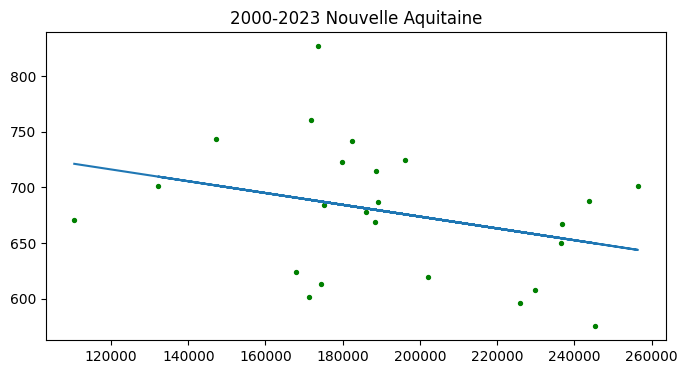

R Value : -0.32332439623344417


In [139]:
x = dfFinalYear['RR']
y = dfFinalYear['CULT_REND']
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 

# Calculate y values for the regression line using list comprehension
y_pred = [slope * xi + intercept for xi in x]
# Create scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(x, y, color='green', s=8)
plt.title('2000-2023 Nouvelle Aquitaine')

# Add regression line to the plot
plt.plot(x, y_pred)
plt.show()
print(f'R Value : {r_value}')

In [138]:
correlation_matrix = dfFinalYear.corr()
correlation_matrix

,CULT_SURF,CULT_REND,CULT_PROD,Year Recolte,Yield deviation from mean,UV,GLOT,DHUMEC,DIRT,INST,TX,TN,TM,RR,DG
CULT_SURF,1.000000,0.534691,0.807433,0.150852,0.534691,0.195517,0.123708,0.247534,0.272163,0.407106,-0.309236,-0.492778,-0.401398,-0.149407,0.377996
CULT_REND,0.534691,1.000000,0.901740,0.062445,1.000000,0.108981,0.144146,-0.090887,0.140497,0.139084,-0.086503,-0.330374,-0.204554,-0.323324,0.154306
CULT_PROD,0.807433,0.901740,1.000000,0.029178,0.901740,0.086848,0.049133,0.074736,0.132376,0.191999,-0.255668,-0.447811,-0.359554,-0.273091,0.196678
Year Recolte,0.150852,0.062445,0.029178,1.000000,0.062445,0.904821,0.858809,-0.313503,0.853835,0.739928,0.549847,0.408161,0.568584,0.433094,0.233433
Yield deviation from mean,0.534691,1.000000,0.901740,0.062445,1.000000,0.108981,0.144146,-0.090887,0.140497,0.139084,-0.086503,-0.330374,-0.204554,-0.323324,0.154306
UV,0.195517,0.108981,0.086848,0.904821,0.108981,1.000000,0.881354,-0.460240,0.811558,0.572572,0.513968,0.410798,0.542366,0.385057,0.068674
GLOT,0.123708,0.144146,0.049133,0.858809,0.144146,0.881354,1.000000,-0.359065,0.708013,0.682945,0.548405,0.340451,0.524995,0.275744,0.236269
DHUMEC,0.247534,-0.090887,0.074736,-0.313503,-0.090887,-0.460240,-0.359065,1.000000,-0.277576,0.168032,-0.388589,-0.328954,-0.402515,-0.123913,0.413303
DIRT,0.272163,0.140497,0.132376,0.853835,0.140497,0.811558,0.708013,-0.277576,1.000000,0.751049,0.289672,0.076906,0.271328,0.313949,0.273891
INST,0.407106,0.139084,0.191999,0.739928,0.139084,0.572572,0.682945,0.168032,0.751049,1.000000,0.207003,-0.064157,0.136775,0.284646,0.531859


In [136]:
correlation_matrixMontaison = dfFinalYearMontaison.corr()
correlation_matrixMontaison

,CULT_SURF,CULT_REND,CULT_PROD,Year Recolte,Yield deviation from mean,UV,GLOT,DHUMEC,DIRT,INST,TX,TN,TM,RR,DG
CULT_SURF,1.000000,0.543276,0.809443,0.163150,0.543276,-0.119980,-0.015088,0.238161,-0.328433,-0.082306,-0.136464,-0.123634,-0.142577,0.083820,-0.132965
CULT_REND,0.543276,1.000000,0.905635,0.005394,1.000000,-0.201372,0.040238,-0.033978,0.043957,0.035515,-0.191857,-0.393076,-0.303349,-0.079956,-0.131172
CULT_PROD,0.809443,0.905635,1.000000,0.007944,0.905635,-0.288005,-0.092250,0.102764,-0.220500,-0.115794,-0.315172,-0.364046,-0.383023,0.076866,-0.120618
Year Recolte,0.163150,0.005394,0.007944,1.000000,0.005394,0.308797,0.515014,-0.308453,0.353176,0.476719,0.456237,-0.072900,0.388440,-0.425732,0.256362
Yield deviation from mean,0.543276,1.000000,0.905635,0.005394,1.000000,-0.201372,0.040238,-0.033978,0.043957,0.035515,-0.191857,-0.393076,-0.303349,-0.079956,-0.131172
UV,-0.119980,-0.201372,-0.288005,0.308797,-0.201372,1.000000,0.830132,-0.107207,0.796345,0.807108,0.648899,-0.270246,0.408177,-0.743711,0.444774
GLOT,-0.015088,0.040238,-0.092250,0.515014,0.040238,0.830132,1.000000,-0.173128,0.937342,0.977314,0.792397,-0.175958,0.589001,-0.754977,0.130290
DHUMEC,0.238161,-0.033978,0.102764,-0.308453,-0.033978,-0.107207,-0.173128,1.000000,-0.240613,-0.262598,-0.071500,0.299744,0.017104,0.370874,-0.289555
DIRT,-0.328433,0.043957,-0.220500,0.353176,0.043957,0.796345,0.937342,-0.240613,1.000000,0.955131,0.696959,-0.259935,0.454203,-0.791209,0.222784
INST,-0.082306,0.035515,-0.115794,0.476719,0.035515,0.807108,0.977314,-0.262598,0.955131,1.000000,0.788535,-0.218854,0.577904,-0.816639,0.166198
